# (수업) 시계열 자료분석 실습 4

ACF, PACF, WN

In [20]:
library('tidyverse')
library('forecast')
library('gridExtra')
library('data.table')

## 정상 시계열 생성

In [2]:
z <- rnorm(200)

In [3]:
tmp.data <- data.frame(
    t = 1:length(z),
    z = z
    )

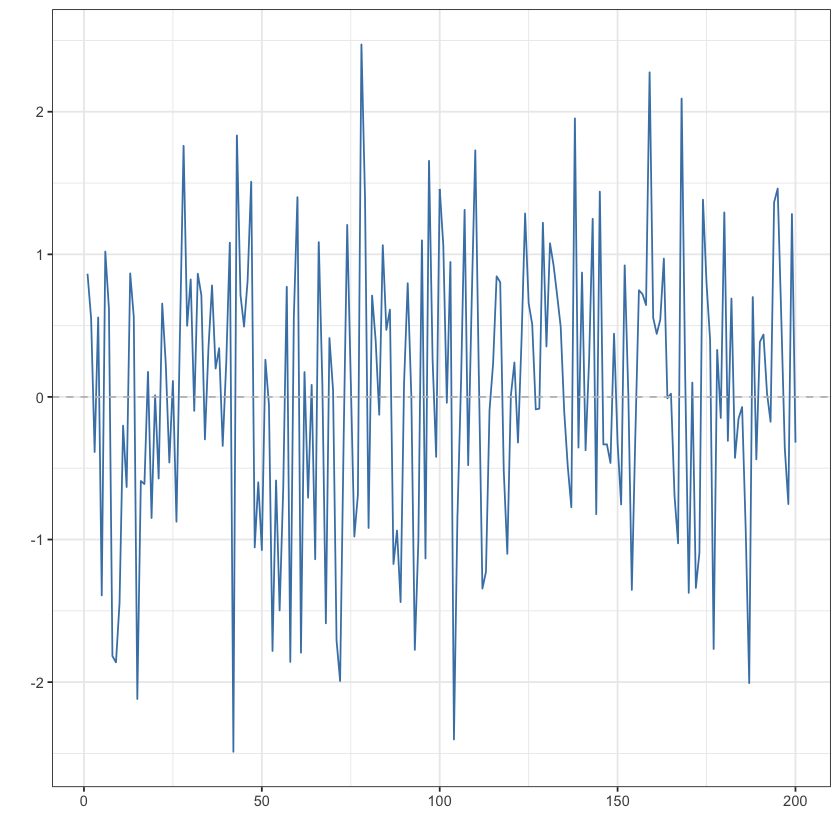

In [4]:
ggplot(tmp.data, aes(t, z)) +
geom_line(col = 'steelblue') +
xlab("") + ylab("") +
geom_hline(yintercept = 0, lty = 2, col = 'grey') +
theme_bw()

- 추세가 없고 분산이 일정한 시계열(정상 시계열)이 나옴.<br>
다만 시도표만 보아서는 이게 확실한 정상 시계열인가가 판별 불가

### list description for MA(1) model

- 결국<br>
$z_t$ = $\mu + e_t$ - $\theta$*$e_{t-1}$<br>
그리고<br>$e_t$ ~ $wn(0, \sigma^2)$

In [5]:
ma1_sim <- function(mu, theta, sigma, n){
    z <- rep(0, n*2)
    e <- rnorm(n*2, 0, sigma^2)
    z[1] <- mu + e[1] # 첫 번째는 손으로 입력
    
    for(k in 2:(n*2)){
        z[k] <- mu + e[k] - theta*e[k-1]
        }
    
    return(z[-(1:n)]) # 우리는 100개만 생성하고 싶었으므로 200개 만든 것중 뒤에 거 100개만 선택
    }

In [6]:
tmp.data <- data.frame(
    t = 1:100,
    z1 = ma1_sim(10, 0.7, 2, 100),
    z2 = ma1_sim(10, 0.3, 2, 100),
    z3 = ma1_sim(10, -0.3, 2, 100),
    z4 = ma1_sim(10, -0.7, 2, 100)
    )

In [7]:
tmp.data %>% head

,t,z1,z2,z3,z4
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,14.349929,8.141987,9.350824,12.945966
2,2,8.292714,6.971182,8.870232,10.584838
3,3,18.901545,4.104496,18.249705,14.260885
4,4,2.533090,12.662785,9.515531,20.006494
5,5,8.122628,11.273591,12.695128,17.244600
6,6,4.082102,15.688632,12.747108,5.179806


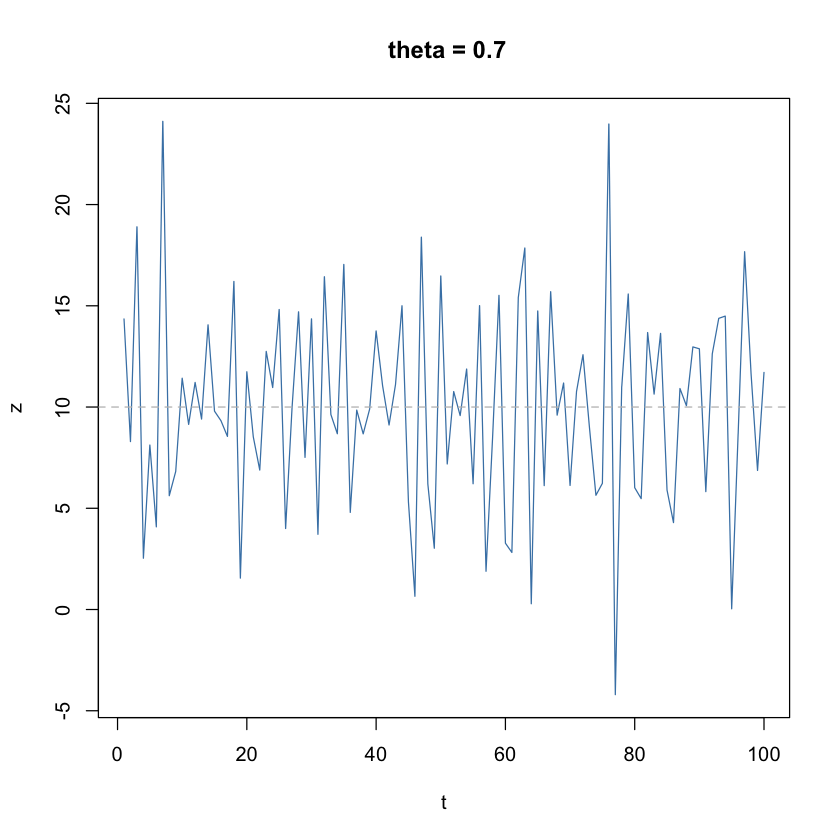

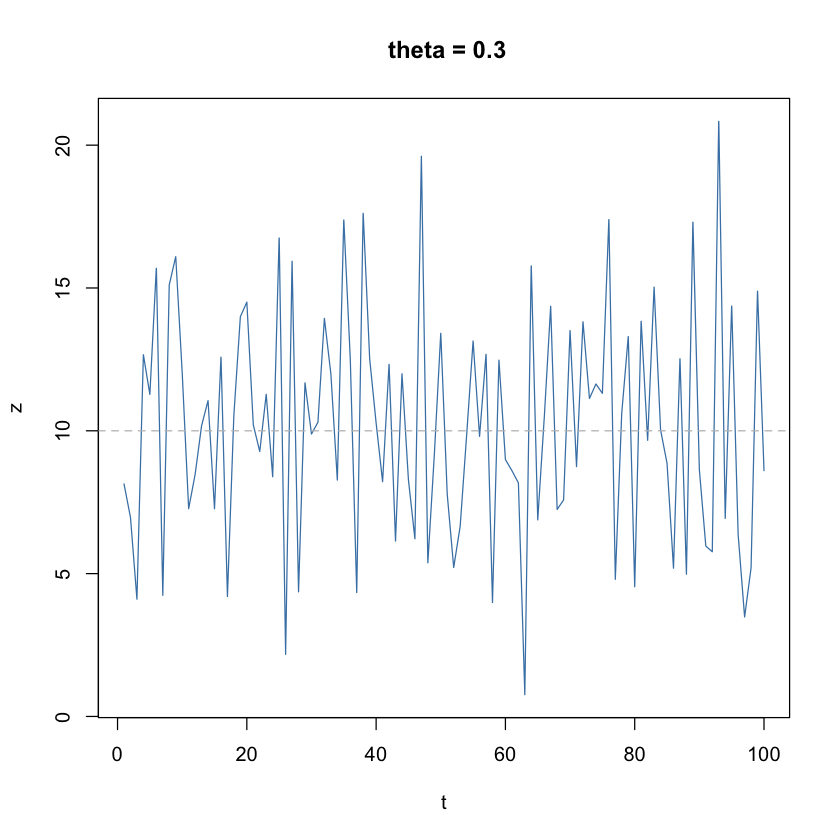

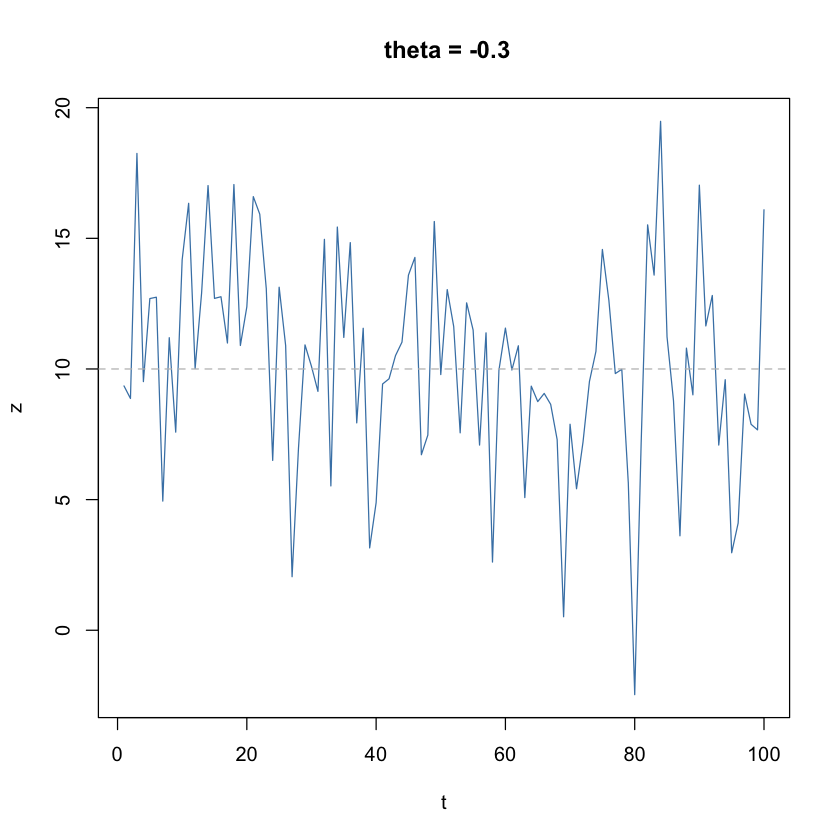

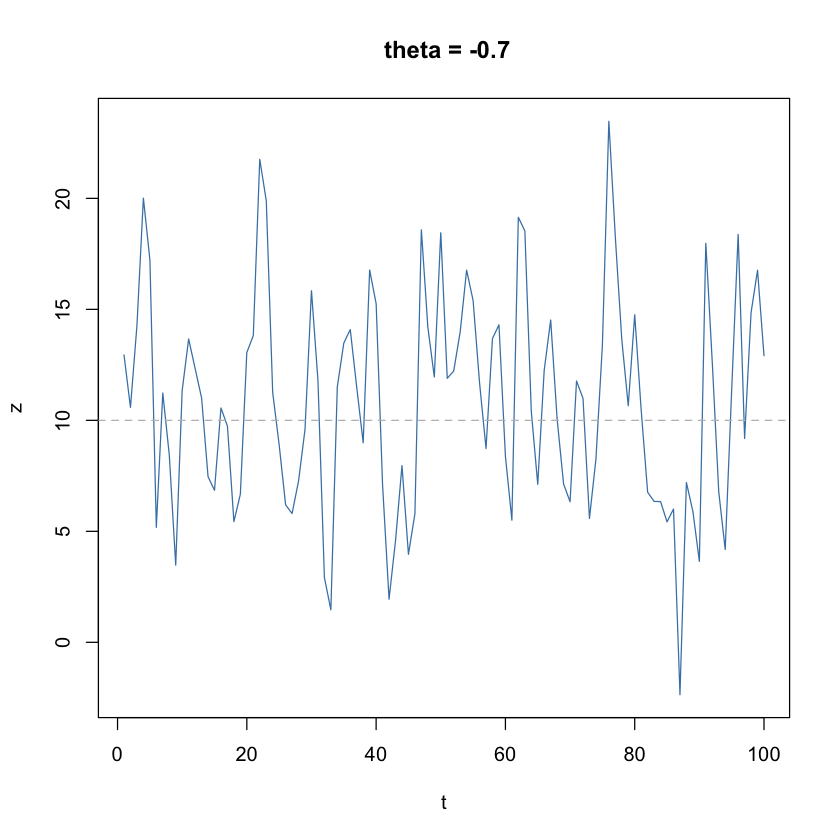

In [8]:
theta <- c(0.7, 0.3, -0.3, -0.7)
for(k in 1:4){
    plot(tmp.data$t, tmp.data[, (k+1)], type = 'l',
         col = 'steelblue',
         main = paste0(' theta = ', theta[k]),
         xlab = 't',
         ylab = 'z')
    abline(h = 10, col = 'grey', lty = 2)
    }

- 분산이 다름.<br>
0.3이 덜 왔다갔다함. 0.7이 더 큼.<br>
3번째는 덜 함. 2번째보다 4번째는 3번째보다도 덜 함.<br>
TimeSeriesModel만 보아서는 이게 $ma(1)$모델인지 알아 볼 수 없음.

#### ACF

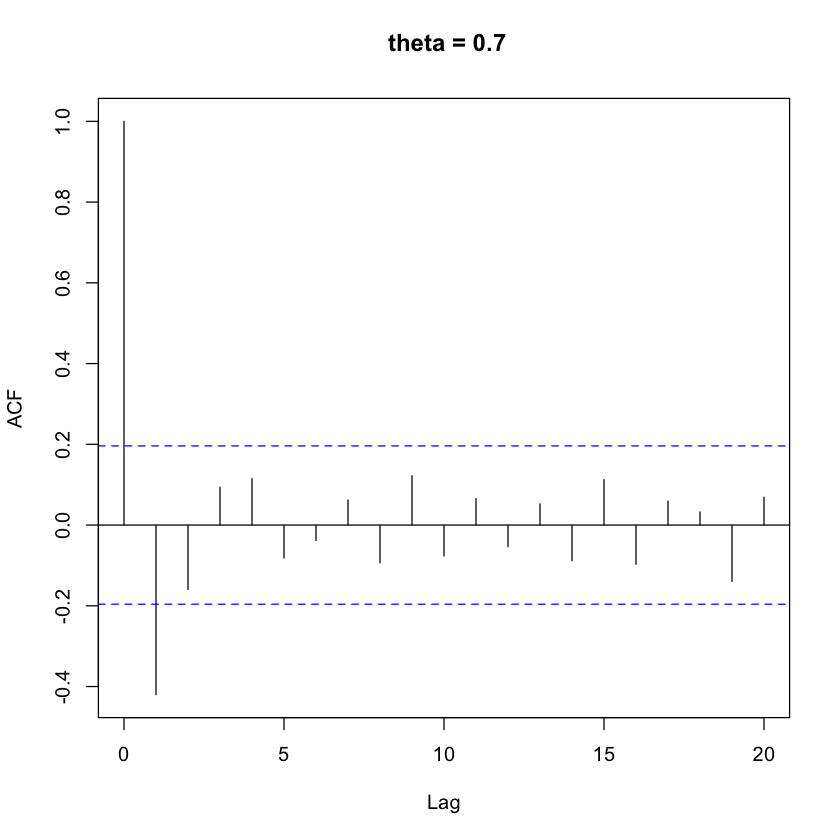

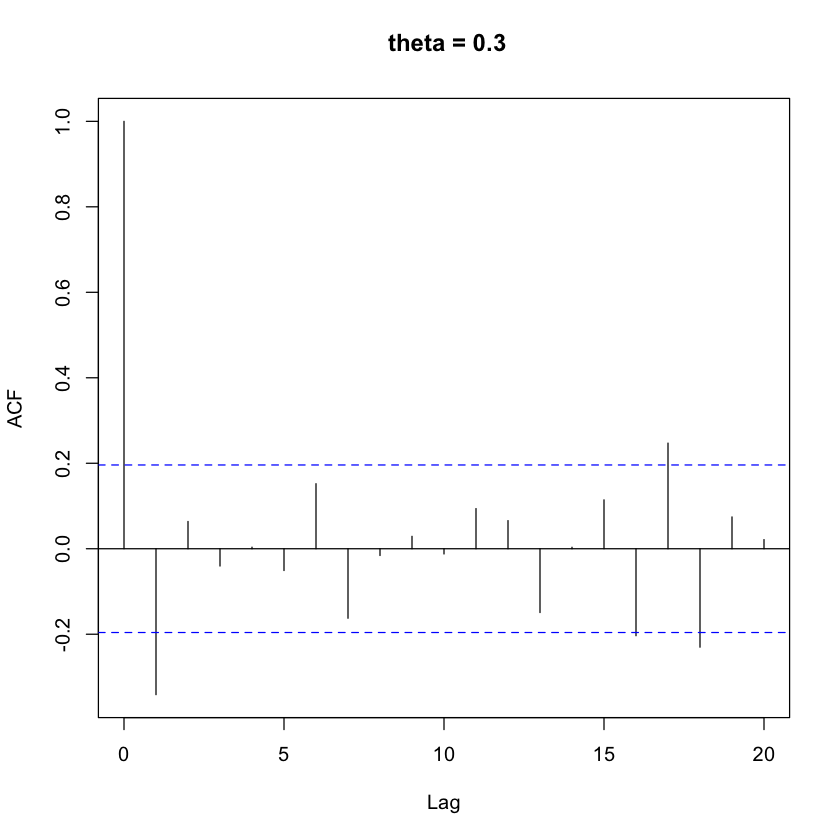

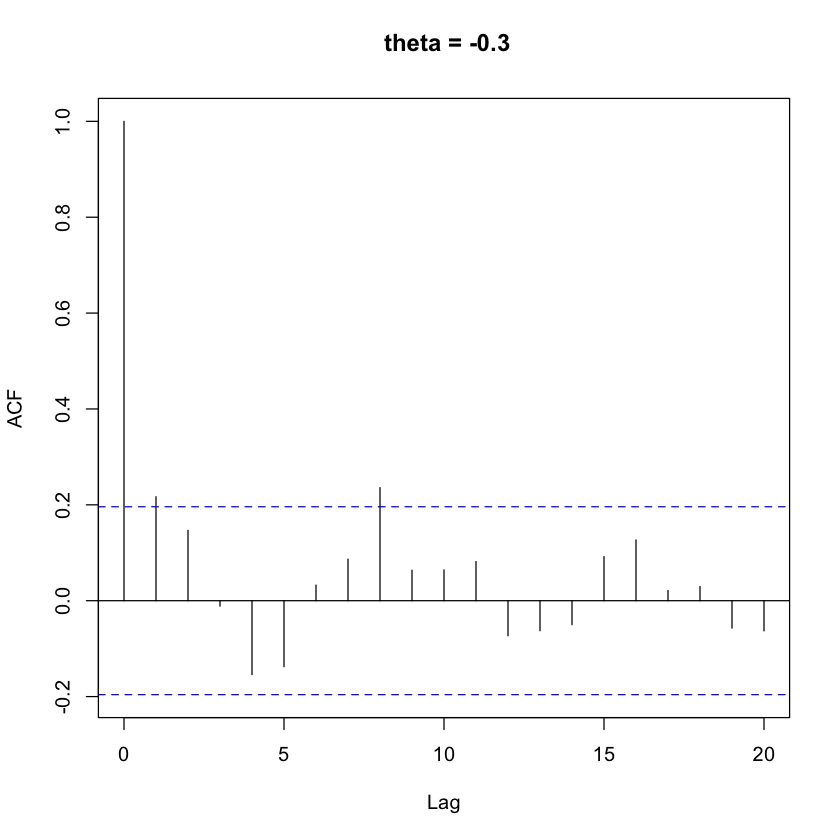

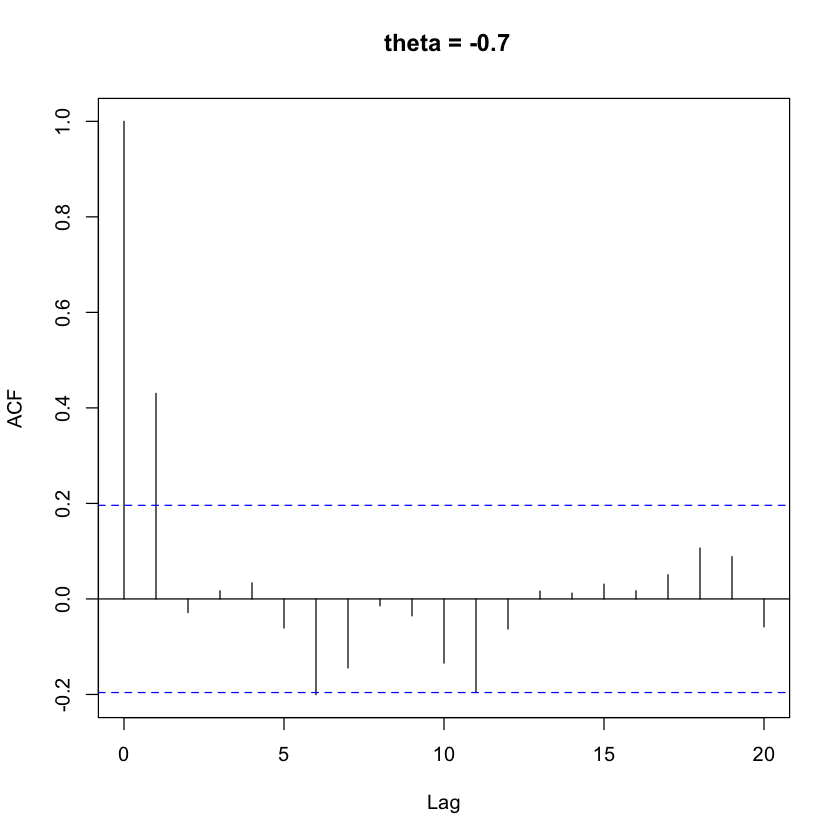

In [9]:
for(k in 1:4){
    acf(tmp.data[, (k+1)],
        main = paste0(' theta = ', theta[k]))
    }

- 해석 : 일단, ACF에서 첫번째 시차가 0인 경우는 무조건 ACF가 1임.<br>
그래서 첫 번째 값을 보면 $\theta$ = 0.7, 0.3일 때 ACF = 0.5, -0.4정도 나오는데 작아지는 모습을 보임.<br>
$\theta$ = 0.7, -0.7인 경우를 비교하면 전자는 acf의 첫번째 시차의 acf가 음수인데, 후자의 경우 양수가 나옴.<br>
이유는 corr이 음수면 방향이 계속 바뀔려고 하고 corr이 양수면 같은 부호에서 머물려고함.<br>
$\theta$의 절댓값에 커짐에 따라 변동폭이 커짐.

- 파란선은 귀무가설을 기각하기 위한 임계치선<br>
0.2에 선이 그어진 이유가 $H_0$ : $\rho$ = 0의 기각역이 $2/\sqrt{n}$ 에서 n = 100이여서(2는 사실 엄밀히 1.96)<br>
간혹 삐쭉삐쭉 나온 것들 있는데 그정도는 무시<br>
즉, 정리하면 파란선 안쪽은 다 0이다.<br>
첫 번째 시차만 살아남고(=$\rho_1$) 나머지는 다 0<br>
이러한 ACF의 형태까지 보면 우리는 이거 MA모형인가 식별가능

#### PACF

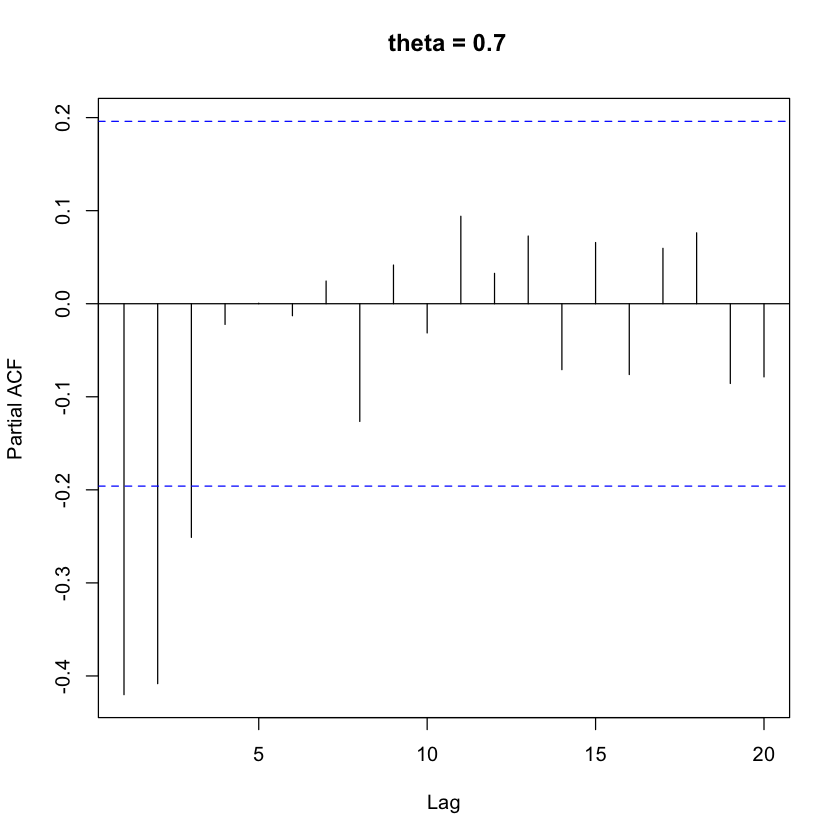

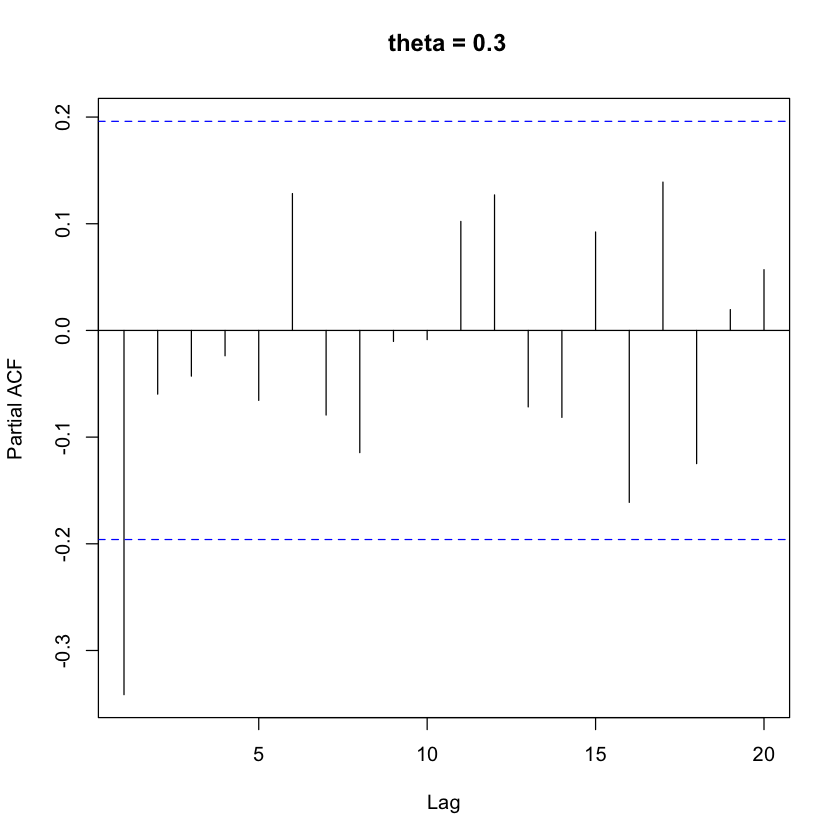

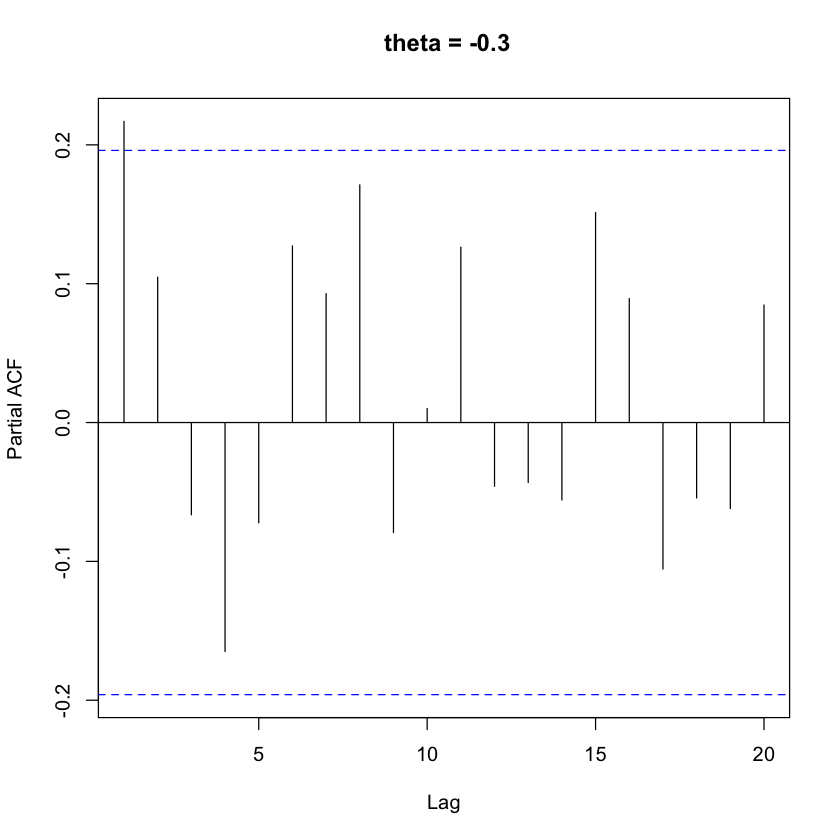

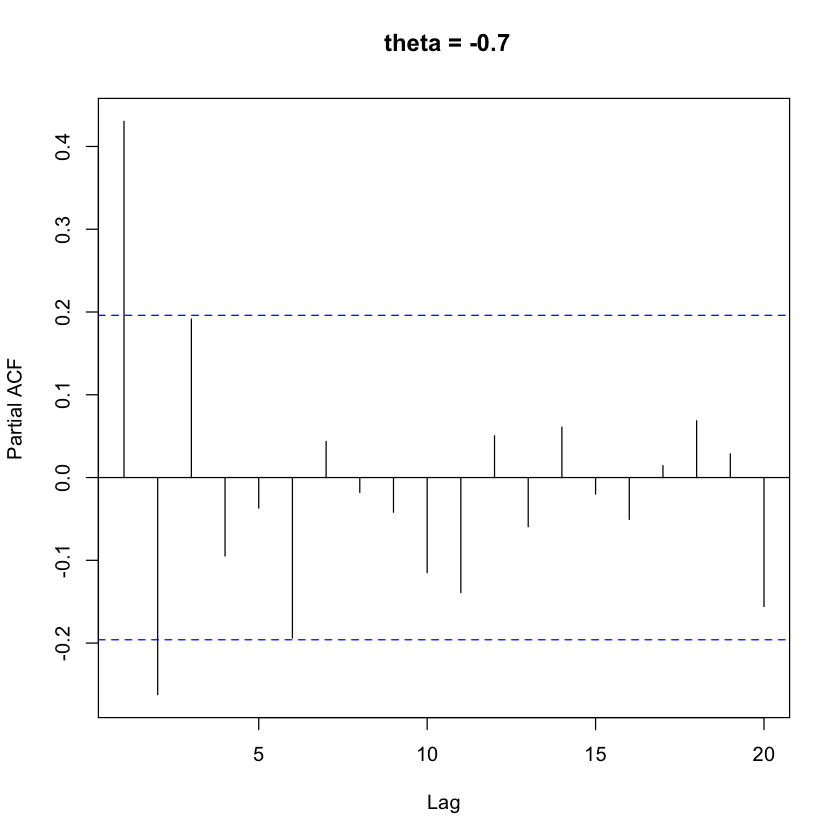

In [10]:
for(k in 1:4){
    pacf(tmp.data[, (k+1)],
         main = paste0(' theta = ', theta[k]))
    }

- 해석 : 맨 처음 값들은 $\rho_1$들이고 이는 $\phi_{11}$ 이다.<br>
두 번째 $\theta$ = 0.3인 경우를 보면 $\theta$가 작아서 그런지 유의하지 않게 나옴.<br>
ACF같은 경우 첫 번째 시차만 살아남고 나머지 다 0이고<br>
PACF의 경우 살아남은 것들이 좀 더 있지만 부호가 바뀌면서(sin곡선을 그리며) 감소하는 추세를 보임.<br>
그래서 우리는 ACF, PACF를 그려보고 MA모형인지 AR모형인지 등등 알아내면 된다.

### iid 정규분포 (백색잡음)

In [11]:
z <- rnorm(100)

tmp.data <- data.table(
  t = 1:length(z),
  z = z
)

- 예쁘게 그리기<br>
ggplot에서 ACF쓸려면 ggAcf사용하면된다.<br>
PACF사용하려면 ggPacf사용하면 됨.

In [12]:
p1 <- ggplot(tmp.data, aes(t, z)) +
geom_line(col = 'steelblue', lwd = 1) +
xlab("") + ylab("") +
ggtitle('Time series plot of iid N(0,1)') +
geom_hline(yintercept = 0, lty = 2, col = 'grey') +
theme_bw()

p2 <- ggAcf(z) +
theme_bw() + ylim(-1, 1) +
theme(plot.title = element_blank())

p3 <- ggPacf(z) +
theme_bw() + ylim(-1, 1) +
theme(plot.title = element_blank())

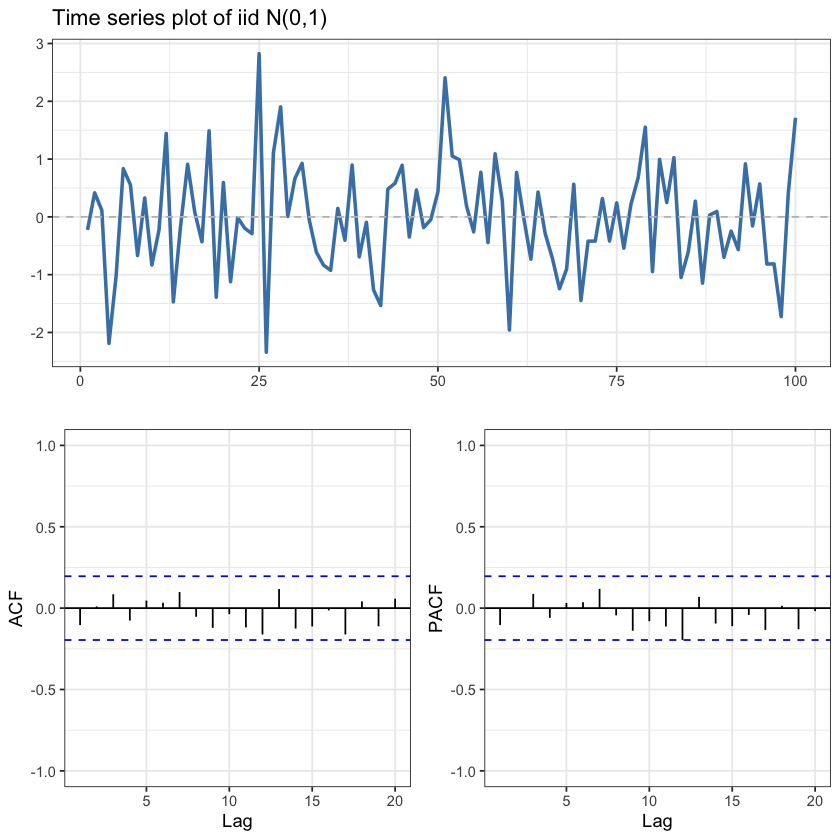

In [13]:
grid.arrange(p1, p2, p3, nrow = 2,
             layout_matrix = rbind(c(1, 1),
                                   c(2, 3)))

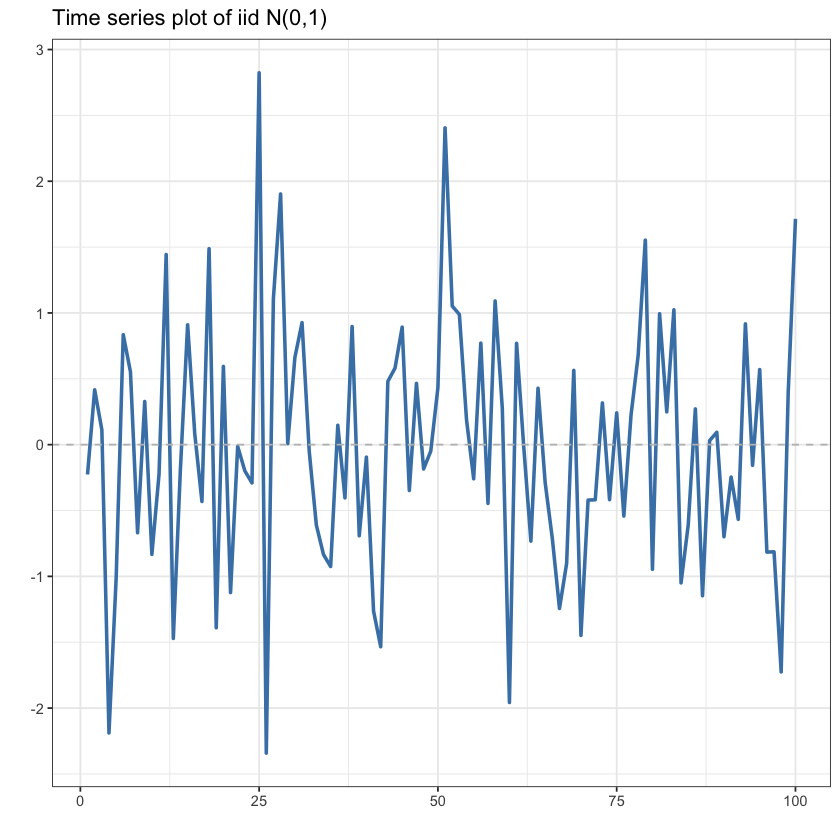

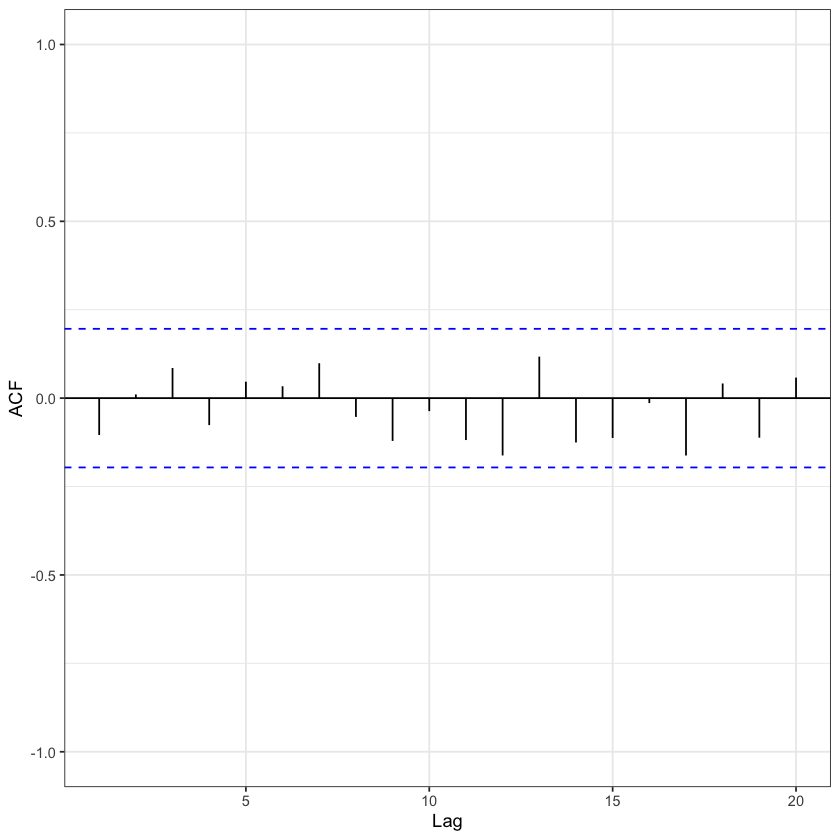

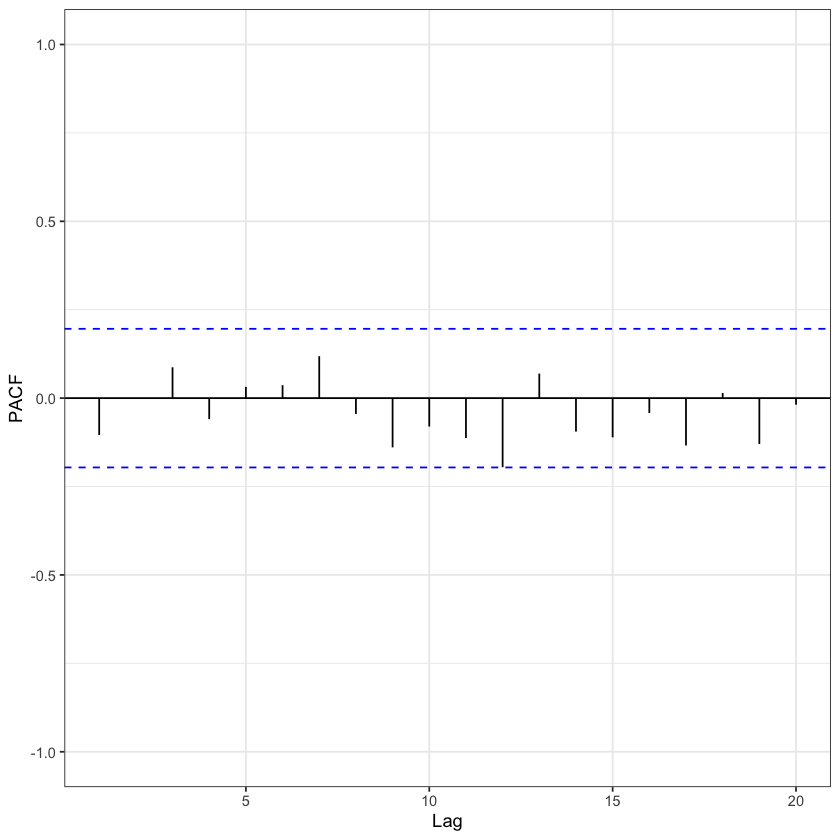

In [14]:
p1
p2
p3

- wn이기에 $\rho$들은 거의 다 0이여야한다.<br>
실제로 보면 전부다 0에 가까운 숫자들임.<br>
나중에 잔차 검증할 때에도 사용

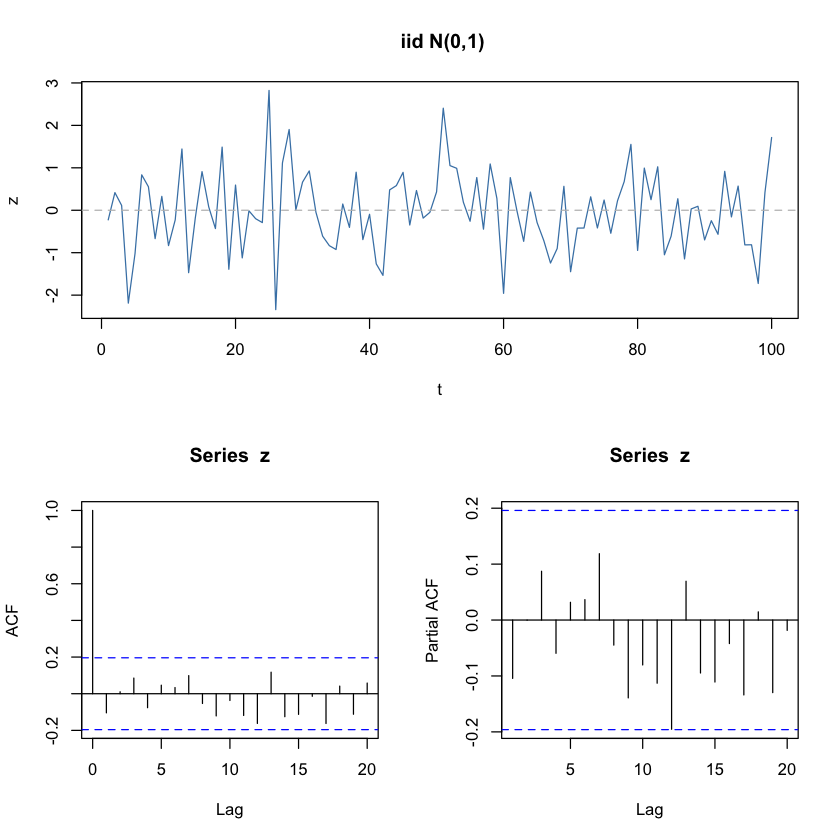

In [15]:
layout(matrix(c(1, 1, 2, 3), 2, 2, byrow = TRUE))
plot(z~t, tmp.data, type = 'l',
col = 'steelblue',
main = paste0(' iid N(0,1)'),
xlab = 't',
ylab = 'z')
abline(h = 0, col = 'grey', lty = 2)

acf(z)
pacf(z)
graphics.off()

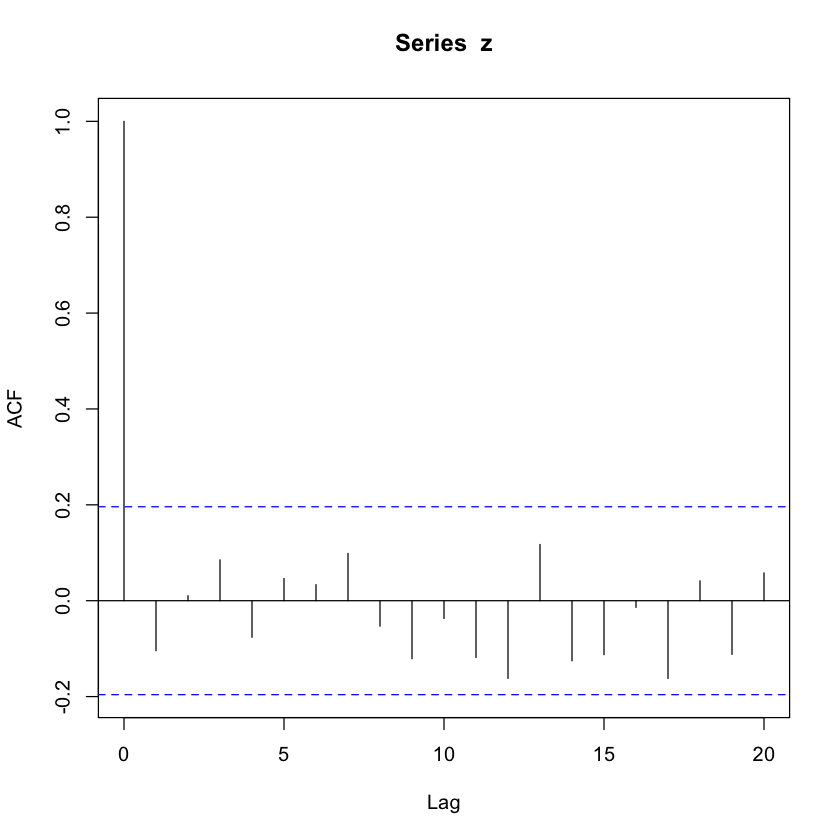

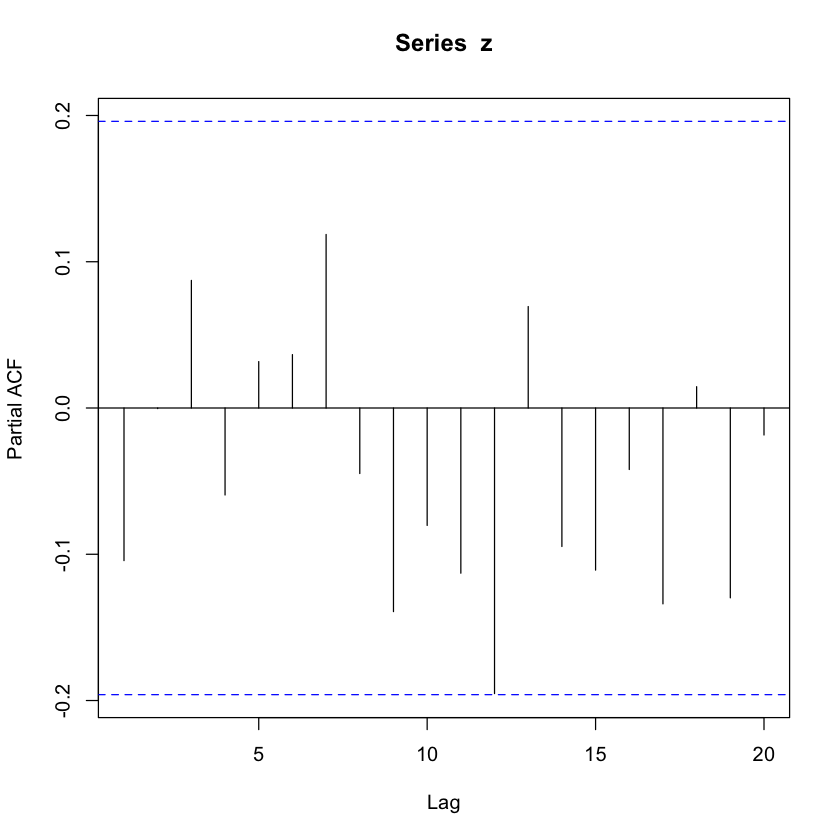

In [16]:
acf(z)
pacf(z)
graphics.off()

### 여러가지 데이터에 대한 ACF PACF 그림

#### sin

- 추세법이나 분해법 사용시 sin함수 사용한 것처럼, 위에서 시작해서 위까지 즉, 밑에 보면 주기가 6인 사인함수<br>

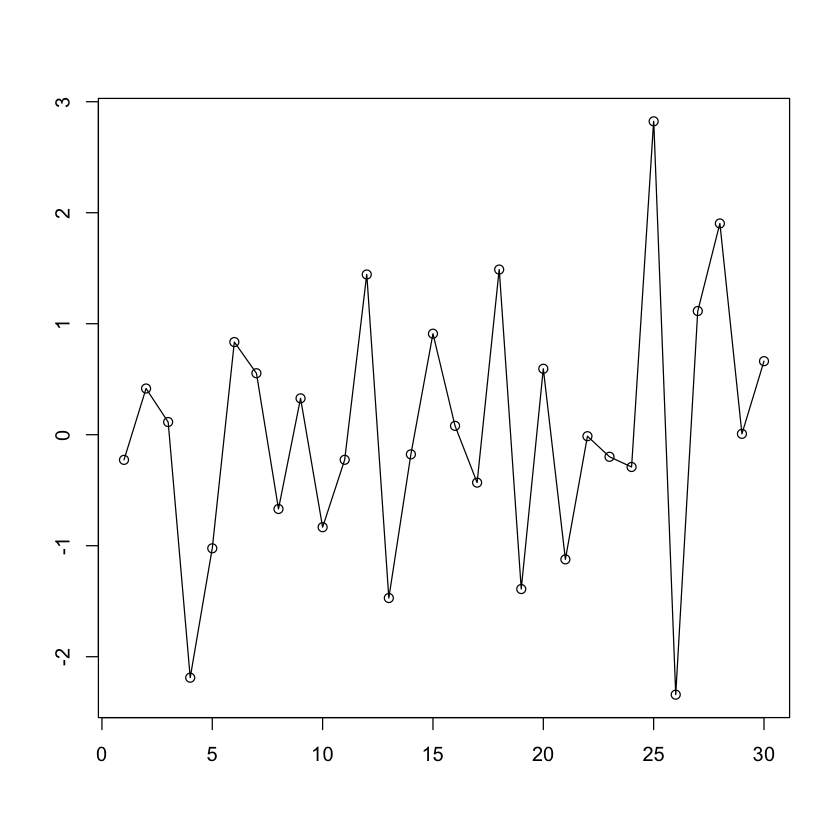

In [17]:
t <- 1:100
y <- sin(t*pi/3)
plot(z[1:30], type = 'o', ylab = '', xlab = '')

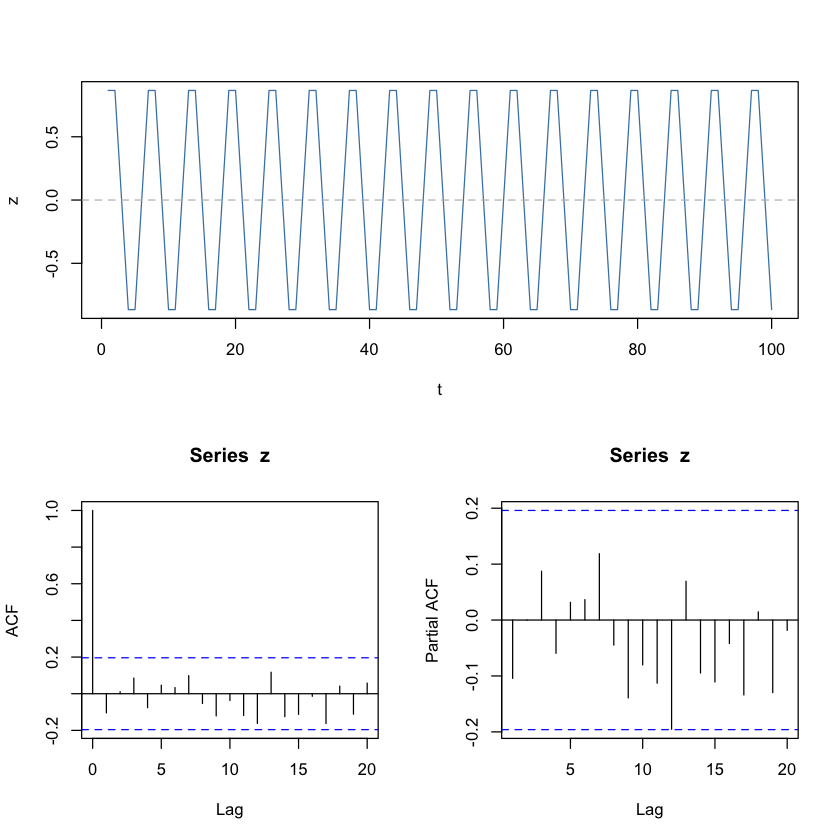

In [18]:
layout(matrix(c(1, 1, 2, 3), 2, 2, byrow = TRUE))
plot(t, y, type = 'l',
     col = 'steelblue',
     xlab = 't',
     ylab = 'z')
abline(h = 0, col = 'grey', lty = 2)

acf(z)
pacf(z)
graphics.off()

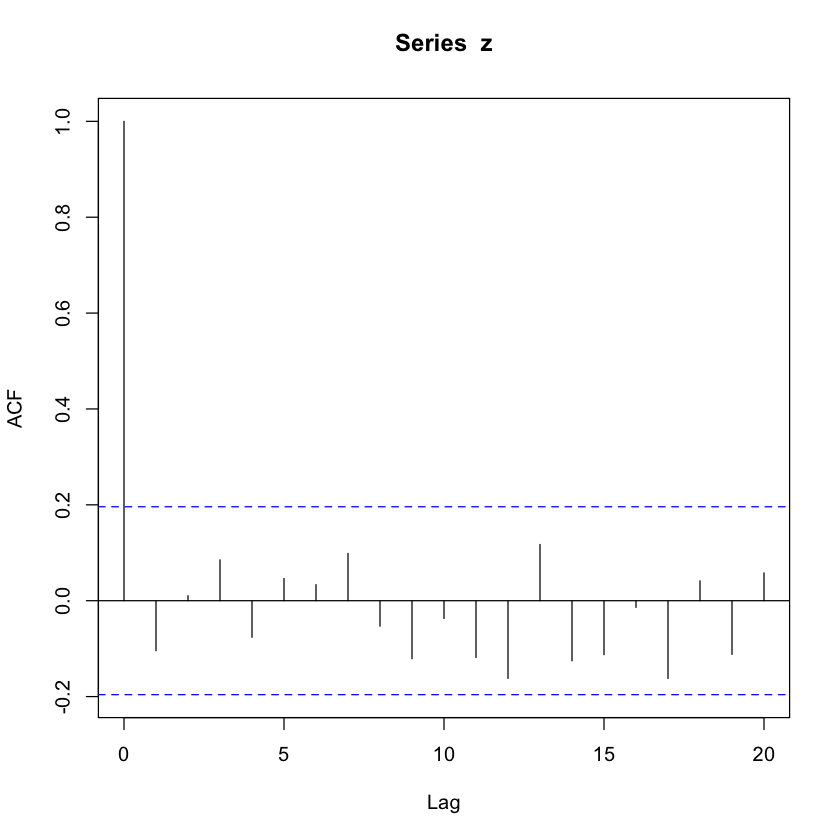

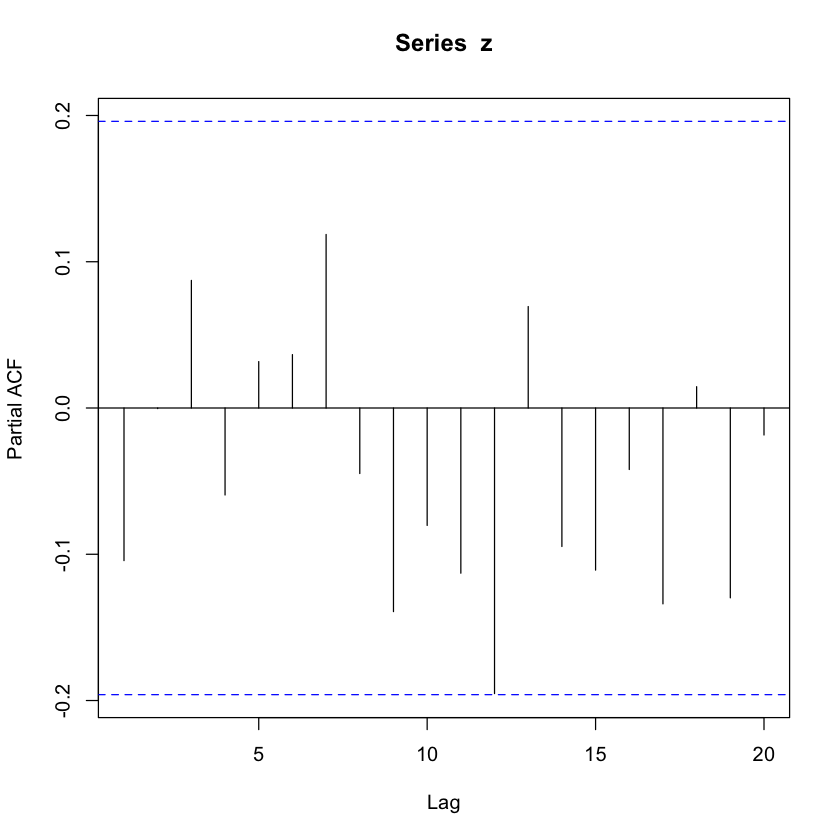

In [19]:
acf(z)
pacf(z)

- 해석 : ACF보면 주기가 6인 사인함수이기에 6마다 corr이 1인 모습을 볼 수 있음.<br>
그리고 3칸가면 무조건 부호 바뀜. 따라서 위의 ACF그림 같은 경우는 3, 9.. 마다 -인 것을 볼 수 있음.<br>
PACF보면 6넘어가는 시점부터는 거의 다 0임. 이게 주기가 6이다 보니 6정도 지나면 PACF라는 것이 딱 두 개만의 관계를 설명하고 나머지를 배제하는 것이기에 이미 한 바퀴 돈 시점부터 이전까지의 process는 설명이 끝남. 이후는 같은 내용 반복이므로 설명할 내용이 없기에 PACF = 0에 가까이 나옴.

- 추세가 있는 경우도 마찬가지.<br>
앞의 것들이 이미 설명함.

### 비행기 메모 추가

36p 비행기 그림보면<br>
선형성 강하게 나오는 것들 있는데 1, 12완전 직선 느낌 등등 -> 계절성이 있구나<br>
4, 5는 별 거 없다 -> 연관 별로 없구나